# Notebook to explore netCDF files and change resolution, plus Python plotting
These files are downloaded from [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=download), using `cdsapi`. Get the data running the Python script `inout.py`:
```
python onehealth_db/inout.py
```

The downloaded files are stored in `data/in`. The `area` option uses values `90`, `90`, `-90`, `-90` for `North`, `East`, `South`, `West`, respectively.

In [1]:
from pathlib import Path
import xarray as xr
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

In [2]:
folder_path = Path("../data/in")
f_area_before_celsius = folder_path / "era5_data_2024_01_02_monthly_area.nc"
f_area_after_celsius = folder_path / "era5_data_2024_01_02_monthly_area_celsius.nc"

In [3]:
# load netCDF files
ds_area_before_celsius = xr.open_dataset(f_area_before_celsius)
ds_area_after_celsius = xr.open_dataset(f_area_after_celsius)

The following cells aim to explore the data structure

In [4]:
ds_area_before_celsius

<xarray.Dataset> Size: 26MB
Dimensions:     (valid_time: 2, latitude: 1801, longitude: 1801)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 16B 2024-01-01 2024-02-01
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 14kB -90.0 -89.9 -89.8 ... 89.8 89.9 90.0
    expver      (valid_time) <U4 32B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 26MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-02T07:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
ds_area_before_celsius.sel(latitude=20.0, longitude=10.0, method="nearest").to_dataframe().head(5)

,number,latitude,longitude,expver,t2m
valid_time,,,,,
2024-01-01,0,20.0,10.0,0001,288.086823
2024-02-01,0,20.0,10.0,0001,290.328491


In [6]:
ds_area_after_celsius

<xarray.Dataset> Size: 26MB
Dimensions:     (valid_time: 2, latitude: 1801, longitude: 1801)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 16B 2024-01-01 2024-02-01
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 14kB -90.0 -89.9 -89.8 ... 89.8 89.9 90.0
    expver      (valid_time) <U4 32B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 26MB ...

In [6]:
ds_area_after_celsius.sel(latitude=20.0, longitude=10.0, method="nearest").to_dataframe().head(5)

,number,latitude,longitude,expver,t2m
valid_time,,,,,
2024-01-01,0,20.0,10.0,0001,14.936829
2024-02-01,0,20.0,10.0,0001,17.178497


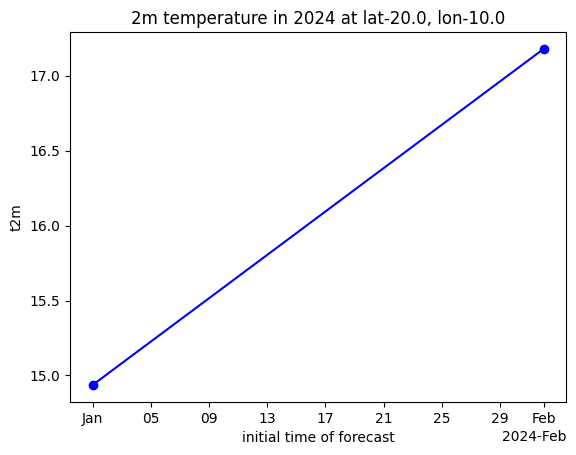

In [7]:
lat = 20.0
lon = 10.0
ds_area_after_celsius["t2m"].sel(latitude=lat, longitude=lon, method="nearest").plot(color="blue", marker="o")
plt.title("2m temperature in 2024 at lat-{}, lon-{}".format(lat, lon))
plt.show()


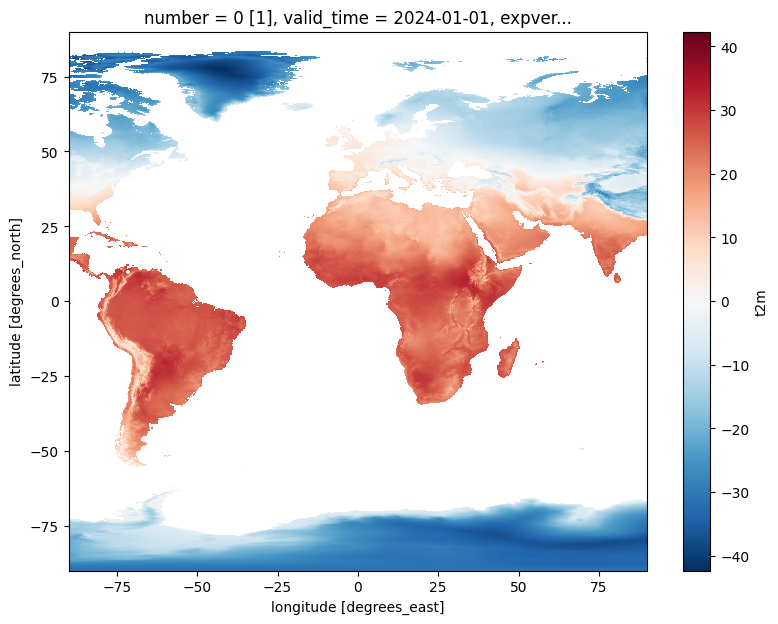

In [ ]:
# plot the data for the first month
ds_area_after_celsius.t2m[0].plot(size = 7)

In [8]:
# convert to dataframe
df = ds_area_after_celsius.to_dataframe().reset_index()
df

,valid_time,latitude,longitude,number,expver,t2m
0,2024-01-01,90.0,-90.0,0,0001,NaN
1,2024-01-01,90.0,-89.9,0,0001,NaN
2,2024-01-01,90.0,-89.8,0,0001,NaN
3,2024-01-01,90.0,-89.7,0,0001,NaN
4,2024-01-01,90.0,-89.6,0,0001,NaN
...,...,...,...,...,...,...
6487197,2024-02-01,-90.0,89.6,0,0001,-38.30394
6487198,2024-02-01,-90.0,89.7,0,0001,-38.30394
6487199,2024-02-01,-90.0,89.8,0,0001,-38.30394
6487200,2024-02-01,-90.0,89.9,0,0001,-38.30394


## Downsampling of the data and setting the correct accuracy for the dataframe

In [ ]:
# aggregate the data to a 1/2 degree grid, about 50km x 50 km
# already here the numerical accuracy of the grid values is problematic, so we need to round
output_grid_resolution = 1/2
input_grid_resolution = np.round((ds_area_after_celsius.longitude[1]-ds_area_after_celsius.longitude[0]).item(),2)
print("Initial grid resolution is {}, downsampling to {} degree resolution".format(input_grid_resolution, output_grid_resolution))
weight = int(np.ceil(output_grid_resolution / input_grid_resolution))
print("Weight is {}".format(weight))

Initial grid resolution is 0.1, downsampling to 0.5 degree resolution
Weight is 5


In [16]:
ds_area_after_celsius_resampled = ds_area_after_celsius.coarsen(longitude=weight, boundary="pad").mean().coarsen(latitude=weight, boundary="pad").mean()
ds_area_after_celsius_resampled

<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 2, latitude: 361, longitude: 361)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 16B 2024-01-01 2024-02-01
  * latitude    (latitude) float64 3kB 89.8 89.3 88.8 88.3 ... -89.2 -89.7 -90.0
  * longitude   (longitude) float64 3kB -89.8 -89.3 -88.8 ... 89.2 89.7 90.0
    expver      (valid_time) <U4 32B '0001' '0001'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 1MB nan nan ... -38.3

In [20]:
downsampled_grid = float(ds_area_after_celsius_resampled.longitude[1] - ds_area_after_celsius_resampled.longitude[0])
print("Downsampled grid resolution is {}".format(downsampled_grid))

Downsampled grid resolution is 0.4999999999999858


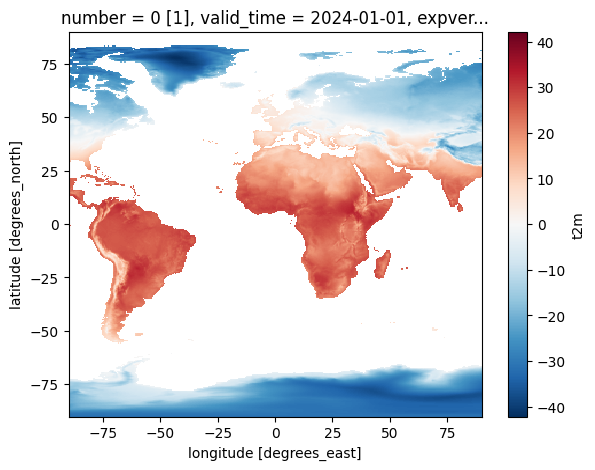

In [19]:
# plot the data for the first month
ds_area_after_celsius_resampled.t2m[0].plot(size = 5)

In [21]:
# convert to dataframe
df = ds_area_after_celsius_resampled.to_dataframe().reset_index()
df

,valid_time,latitude,longitude,t2m,number,expver
0,2024-01-01,89.8,-89.8,NaN,0,0001
1,2024-01-01,89.8,-89.3,NaN,0,0001
2,2024-01-01,89.8,-88.8,NaN,0,0001
3,2024-01-01,89.8,-88.3,NaN,0,0001
4,2024-01-01,89.8,-87.8,NaN,0,0001
...,...,...,...,...,...,...
260637,2024-02-01,-90.0,88.2,-38.30394,0,0001
260638,2024-02-01,-90.0,88.7,-38.30394,0,0001
260639,2024-02-01,-90.0,89.2,-38.30394,0,0001
260640,2024-02-01,-90.0,89.7,-38.30394,0,0001


In [22]:
out_data = df[["valid_time", "latitude", "longitude", "t2m"]]
out_data = out_data[out_data['valid_time'] == '2024-02-01']

In [23]:
# drop all nan values and filter by time
out_data_clean = out_data.dropna()
out_data_clean

,valid_time,latitude,longitude,t2m
135045,2024-02-01,83.3,-74.3,-26.757065
135048,2024-02-01,83.3,-72.8,-28.395737
135052,2024-02-01,83.3,-70.8,-28.923080
135053,2024-02-01,83.3,-70.3,-28.999252
135054,2024-02-01,83.3,-69.8,-28.999252
...,...,...,...,...
260637,2024-02-01,-90.0,88.2,-38.303940
260638,2024-02-01,-90.0,88.7,-38.303940
260639,2024-02-01,-90.0,89.2,-38.303940
260640,2024-02-01,-90.0,89.7,-38.303940


In [24]:
out_data.to_csv("../data/out/era5_data_2024_01_02_monthly_area_celsius_with_NaN_february_resampled_05degree.csv", index=False)
out_data_clean.to_csv("../data/out/era5_data_2024_01_02_monthly_area_celsius_february_resampled_05degree.csv", index=False)

## Export to geopandas for other plotting options and geospatial analysis

In [25]:
# xarray data to geopandas
# Create geometry column using latitude and longitude
geometry = [Point(xy) for xy in zip(out_data_clean['longitude'], out_data_clean['latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(out_data_clean, geometry=geometry)

# Set the coordinate reference system (CRS) if known (e.g., WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Save to a GeoJSON file
gdf.to_file("../data/out/era5_data_2024_01_02_monthly_area_celsius_February_resampled_05degree.geojson", driver="GeoJSON")

# Display the GeoDataFrame
gdf.head()

,valid_time,latitude,longitude,t2m,geometry
135045,2024-02-01,83.3,-74.3,-26.757065,POINT (-74.3 83.3)
135048,2024-02-01,83.3,-72.8,-28.395737,POINT (-72.8 83.3)
135052,2024-02-01,83.3,-70.8,-28.923080,POINT (-70.8 83.3)
135053,2024-02-01,83.3,-70.3,-28.999252,POINT (-70.3 83.3)
135054,2024-02-01,83.3,-69.8,-28.999252,POINT (-69.8 83.3)
